### Modeling procedure
- Plot the data and examnine the main features of the graph, check whether there is a trend, a seasonal component, outliers ...
- Transform the data,
- Test the stationarity of the data,
- Identifying seasonality and trend from a series of data:
  - Classical decomposition
  - Differencing
- Examining the ACF/PACF to determine the value of p or q,
- Trying the chosen model and searching for a better model,
- Checking the residuals from the chosen model,
- Forecasting.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from statsmodels.tsa.api import adfuller, kpss, seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 7]

## Load the dataset

In [ ]:
path = 'https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv'
df = pd.read_csv(path, index_col=['Month'], parse_dates=['Month'])
df.tail()

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


## Analyze the dataset

In [ ]:
# The shape of the dataset
print(df.shape)

# Statistical description
print(df.info())

display(df.describe())

print(f"Min: {df[df['Passengers'] == df['Passengers'].min()]}")

print(f"Max: {df[df['Passengers'] == df['Passengers'].max()]}")

(144, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Min:             Passengers
Month                 
1949-11-01         104
Max:             Passengers
Month                 
1960-07-01         622


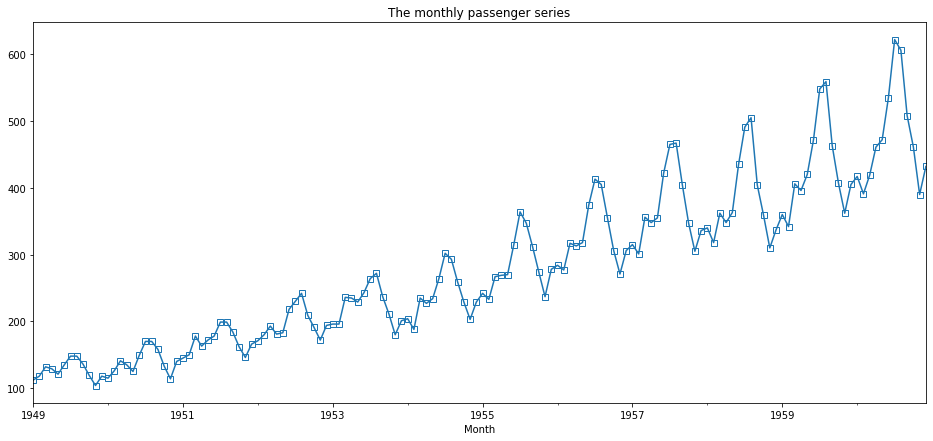

In [ ]:
df['Passengers'].plot(title='The monthly passenger series', legend=False, marker='s',
       mfc='none')
plt.show()

This dataset is a time-series data which shows the number of monthly air passengers from 01-1949 to 12-1960.
- The graph shows a strong seasonal pattern with the maximum for each year occurring in July and the minimum for each year occurring in November.
- The presence of a trend is apparent.


In [ ]:
# Transformation such as logarithms can help to stabilise the variance of a TS
df['log(passengers)'] = np.log(df['Passengers'])

Check stationarity: 
- Augmented Dickey-Fuller test: $H_0$: The series has a unit root.

  If p-value > 0.05, we fail to reject the null hypothesis, this test may provide evidence that the series is non-stationary.
- KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test: $H_0$: the series is stationary.

  If p_value < 0.05, we can reject the null hypothesis and derive that the series is non-stationary.

In [ ]:
def check_stationarity(df):
    adf_results = adfuller(df)[1:3]
    kpss_results = kpss(df)[1:3]
    adf_s = 'Non-Stationary'
    kpss_s = 'Non-Stationary'
    if adf_results[0] < 0.05:
        adf_s = 'Stationary'
    if kpss_results[0] > 0.05:
        kpss_s = 'Stationary'

    tests = ['ADF', 'KPSS']
    pvalues = [adf_results[0], kpss_results[0]]
    is_stationary = [adf_s, kpss_s]
    stationary_df = pd.DataFrame({'tests': tests, 'p-value': pvalues, 'is_stationary': is_stationary})

    return stationary_df
    
check_stationarity(df['Passengers'])

,tests,p-value,is_stationary
0,ADF,0.99188,Non-Stationary
1,KPSS,0.01000,Non-Stationary


## Elimination of Trend and Seasonal Components

### Method S1: Classical Decomposition
$$ X_t = m_t + s_t + Y_t, \,\,\,\,\, t=1,...,n,$$
where $EY_t = 0, \,\, s_{t+d} = s_t, \,\, \sum_{j=1}^{d}s_j = 0$

#### **Step 1**: Estimate trend using a moving average filter of the period length d

In [ ]:
def trend_estimation(series, period):
  trend_list = []
  q = int(period/2)
  history = [series[i] for i in range(period)]
  test = [series[i] for i in range(period, len(series))]

  for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-period,length)])
    obs = test[t]
    trend_list.append(yhat)
    history.append(obs)
    
  return trend_list, test


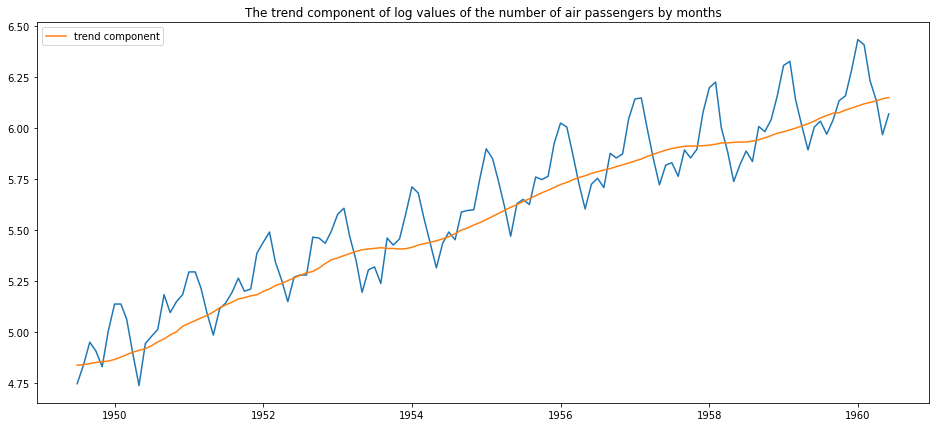

In [ ]:
series = df['log(passengers)'].values
period = 12
q = int(period/2)
index=df.index[q:-q]
trend, test = trend_estimation(series, period)
trend = pd.Series(data = trend, index=index)
test = pd.Series(data = test, index=index)

# Plot trend estimation
plt.plot(test)
plt.plot(trend, label='trend component')
plt.title('The trend component of log values of the number of air passengers by months')
plt.legend()
plt.show()

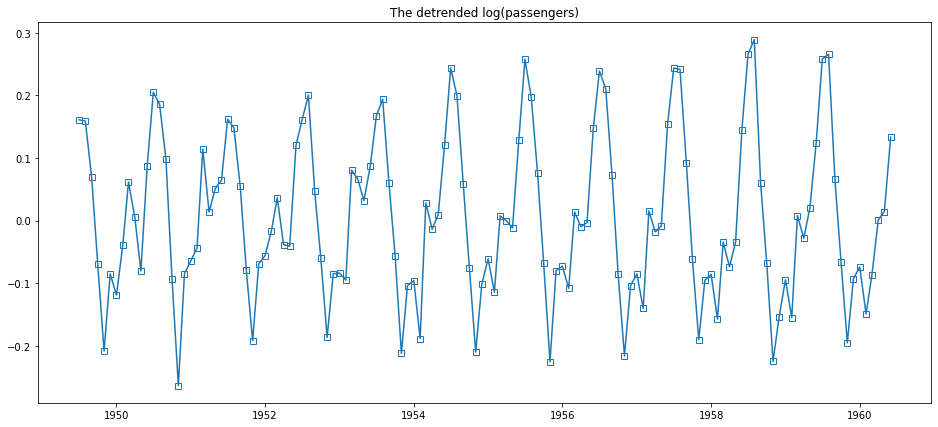

In [ ]:
# Detrending data
detrended = df['log(passengers)'] - trend
plt.plot(detrended, marker='s', mfc='none')
plt.title('The detrended log(passengers)')
plt.show()

####**Step 2**: Estimate the seasonal component

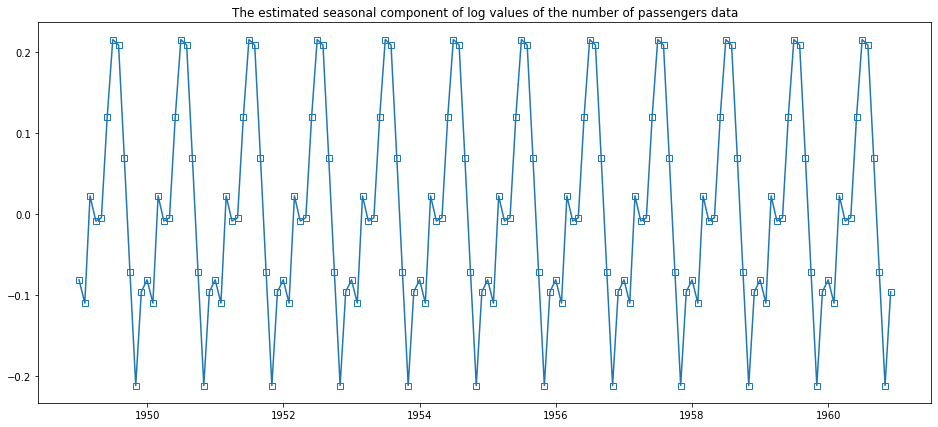

In [ ]:
seasonal = detrended.groupby(by = detrended.index.month).mean()
col = 'log(passengers)'
seasonal_component = copy.deepcopy(df)
for i in seasonal.index:
  seasonal_component.loc[seasonal_component.index.month == i, col] = seasonal.loc[i]

plt.plot(seasonal_component[col], marker='s', mfc='none')
plt.title("The estimated seasonal component of log values of the number of passengers data")
plt.show()

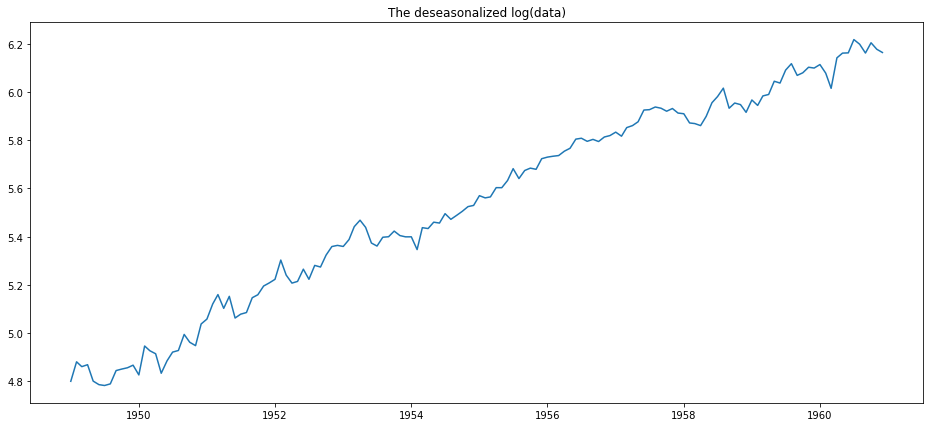

In [ ]:
# Plot the deseasonalized data
deseasonal = df['log(passengers)'] - seasonal_component['log(passengers)']
plt.plot(deseasonal)
plt.title("The deseasonalized log(data)")
plt.show()

#### **Step 3:** The estimated noise series

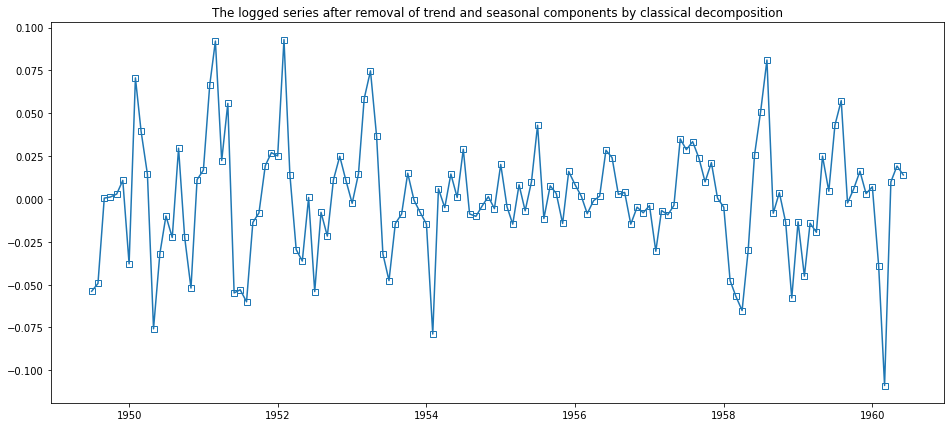

In [ ]:
estimated_noise = df['log(passengers)'] - seasonal_component['log(passengers)'] - trend
plt.plot(estimated_noise, marker='s', mfc='none')
plt.title("The logged series after removal of trend and seasonal components by classical decomposition")
plt.show()

#### Using seasonal_decompose function of statsmodels library

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['log(passengers)'], model='additive', period=12)

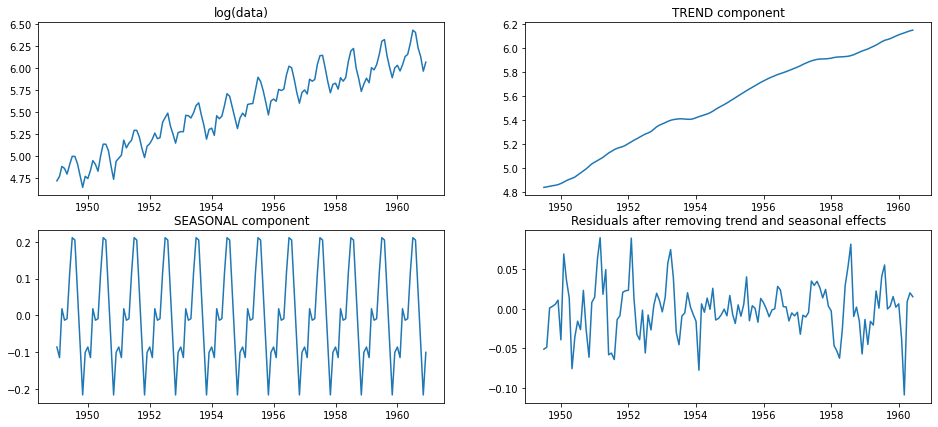

In [ ]:
# Plot
f, (ax1, ax2) = plt.subplots(2, 2)
ax1[0].plot(df['log(passengers)'])
ax1[0].set_title('log(data)')

ax1[1].plot(result.trend)
ax1[1].set_title('TREND component')

ax2[0].plot(result.seasonal)
ax2[0].set_title('SEASONAL component')

ax2[1].plot(result.resid)
ax2[1].set_title('Residuals after removing trend and seasonal effects')
plt.show()


### Method S2: Differencing


In [ ]:
# create a differenced series
def difference(dataset, lag=1):
  diff = list()
  for i in range(lag, len(dataset)):
    value = dataset[i] - dataset[i - lag]
    diff.append(value)
  return diff

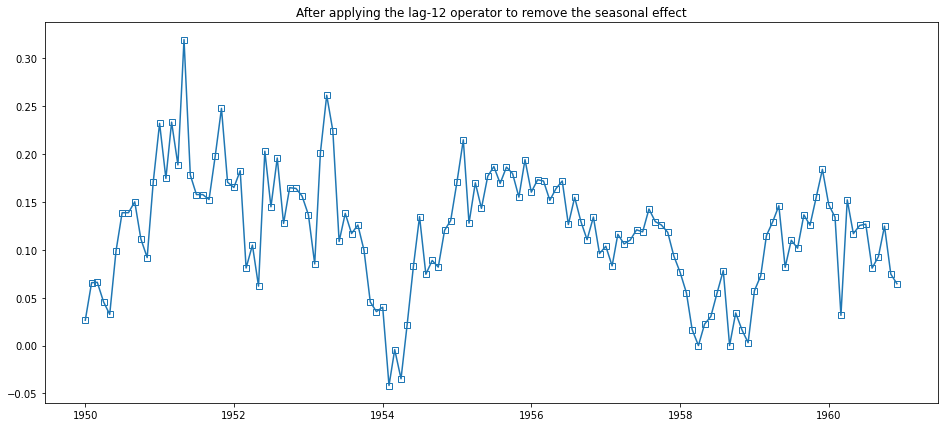

In [ ]:
X = df['log(passengers)'].values
lag=12
index=df.index[lag:]
diff_12 = pd.Series(difference(X, lag), index=index)
plt.plot(diff_12, marker='s', mfc='none')
plt.title("After applying the lag-12 operator to remove the seasonal effect")
plt.show()

There still appears to be a trend. We apply the technique of differencing with lag 1 to {$\nabla_{12}x_t$} again to eliminate the trend component.

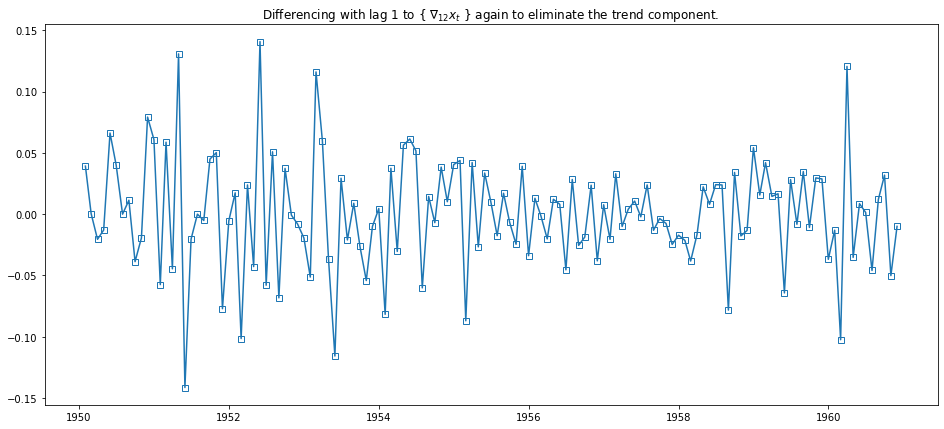

In [ ]:
index_2 = diff_12.index[1:]
diff_12_1 = pd.Series(difference(diff_12, 1), index=index_2)
plt.plot(diff_12_1, marker='s', mfc='none')
plt.title("Differencing with lag 1 to { $∇_{12}x_t$ } again to eliminate the trend component.")
plt.show()

## Fitting a model for the data

The non-stationary data has trend and seasonal component, we consider Seasonal ARIMA model, Seasonal Holt-Winter model.

### SARIMA model

Identifying the value of d, p, q: 
https://people.duke.edu/~rnau/411arim3.htm

#### **Determine the order of differencing 'd'**
The Augmented Dickey-Fuller test can be employed to determine the order of differencing d


In [ ]:
print(check_stationarity(df['log(passengers)']))
print(check_stationarity(diff_12.dropna()))
print(check_stationarity(diff_12_1.dropna()))

('Non-Stationary', 0.4223667747703914)
('Non-Stationary', 0.07239567181769471)
('Stationary', 0.0002485912311384052)


Based on the above results, we consider d = 1, D = 1.

#### **Compute the order for the moving average model 'q'**

“q” can be estimated by looking at the ACF plot.

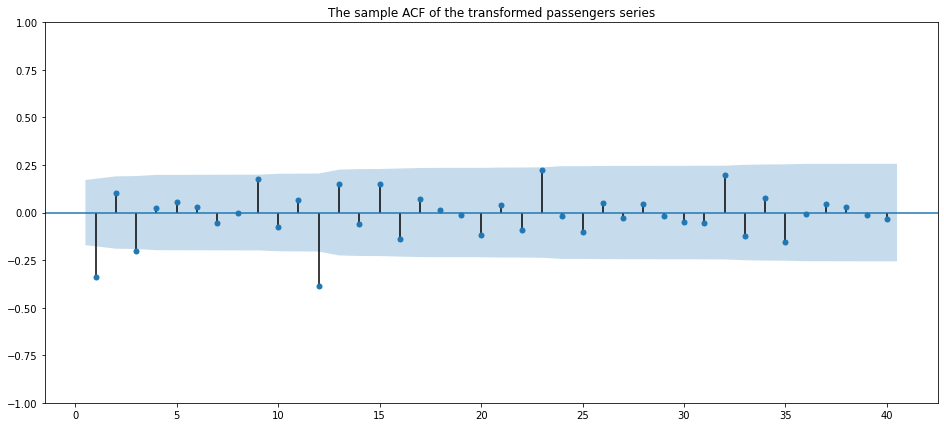

-0.3866128596499148 -0.018418167386414015 -0.009995010112817919


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, acf

plot_acf(diff_12_1, zero=False, lags=40)
plt.title("The sample ACF of the transformed passengers series")
plt.show()

rho = acf(diff_12_1, nlags = 40, fft = False)
print(rho[12], rho[24], rho[36])

- The values $\hat\rho(12) = -0.387$, $\hat\rho(24) = -0.018$, $\hat\rho(36) = 0.0009$ suggest a moving average of order 1 for the between-year model (Q = 1).
- From $\hat\rho(1)$ to $\hat\rho(11)$, we can see $\hat\rho(1)$ is different from 0, the others are mostly lying in the bounds, so we can choose a moving average of order 1 for the between-month model (q = 1).

#### **Compute the order for the autoregressive model 'p'**

We can inspect the partial autocorrelation plot, which measures the correlation between the time-series data and a certain lag. Based on the presence or absence of correlation, we can determine whether the lag or order is needed or not.

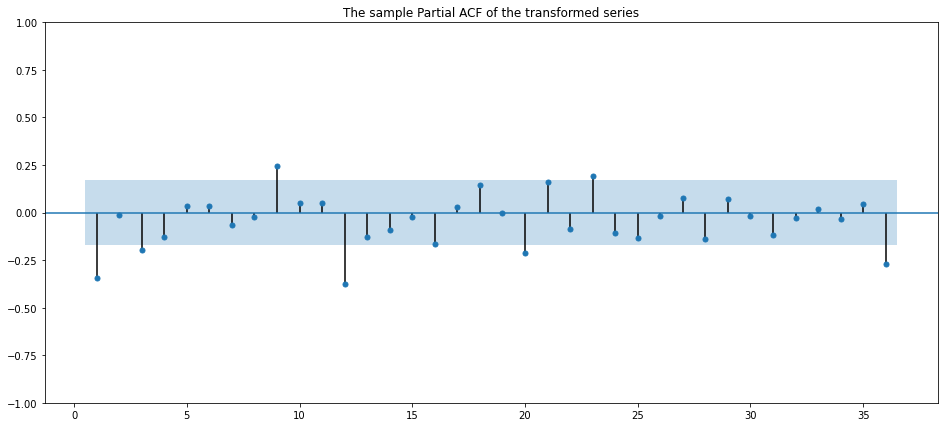

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff_12_1, zero=False, lags=36)
plt.title('The sample Partial ACF of the transformed series')

plt.show()

If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms.

We consider p = 0, P = 0.

### **Fitting a model**

A suggested model is SARIMA(0, 1, 1)(0, 1, 1, 12)


In [ ]:
def split_data(data, test_split):
  l = len(data)
  t_idx = round(l*(1-test_split))
  train, test = data[ : t_idx], data[t_idx : ]
  print(f'train: {len(train)} , test: {len(test)}')
  return train, test

test_split = 0.17
train, test = split_data(df, test_split)

train: 120 , test: 24


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
sarima_model = SARIMAX(train['log(passengers)'], 
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
sarima_result = sarima_model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    log(passengers)   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Sat, 10 Dec 2022   AIC                           -389.010
Time:                                    05:48:45   BIC                           -380.991
Sample:                                01-01-1949   HQIC                          -385.759
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3423      0.087     -3.922      0.000      -0.513      -0.171
ma.S.L12      -0.5408      0.105   

In [ ]:
# this function will compare the different models to select the best model 
# and the set of parameters associated with that model.
def get_best_model(score, c='AIC'):
  initial_score = score[0][c]
  best_model = 0
  for k,v in score.items():
    if v[c] < initial_score:
      initial_score = v[c]
      best_model = k
  print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
  return score[best_model]['model']

# The combinator function takes a list of parameter values and 
# returns a Cartesian product of these choices.
def combinator(items):
  combo = [i for i in product(*items)]
  return combo

In [ ]:
ps = range(0, 3)
qs = range(0, 3)
Ps = range(0, 2)
Qs = range(0, 2)
d = 1
D = 1
vals = combinator([ps, qs, Ps, Qs])
score = {}

for i, (p, q, P, Q) in enumerate(vals):
  m = SARIMAX(train['log(passengers)'],
              order=(p,d,q),
              seasonal_order=(P, D, Q, 12))
  res = m.fit(disp=0)
  y = test['log(passengers)'].values.ravel()
  y_hat = res.forecast(steps=len(y))
  score[i] = {'non-seasonal order': (p,d,q),
              'seasonal order': (P, D, Q),
              'AIC':res.aic,
              'AICc': res.aicc,
              'BIC': res.bic,
              'MAE': mean_absolute_error(y, y_hat),
              'MAPE' : mean_absolute_percentage_error(y, y_hat),
              'model': res}

In [ ]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,MAE,MAPE,model
0,5,"(0, 1, 1)","(0, 1, 1)",-389.009739,-388.776729,-380.991252,0.089569,0.01463,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,13,"(1, 1, 0)","(0, 1, 1)",-388.643149,-388.41014,-380.624663,0.095243,0.015558,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,7,"(0, 1, 1)","(1, 1, 1)",-387.220112,-386.827956,-376.528797,0.088509,0.014458,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,9,"(0, 1, 2)","(0, 1, 1)",-387.065409,-386.673252,-376.374094,0.087919,0.01436,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,15,"(1, 1, 0)","(1, 1, 1)",-386.774608,-386.382451,-376.083292,0.094487,0.015436,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [ ]:
best_model = get_best_model(score, 'AIC')

Best model: 5 with lowest AIC score: -389.009738727877


In [ ]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    log(passengers)   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Fri, 09 Dec 2022   AIC                           -389.010
Time:                                    03:45:44   BIC                           -380.991
Sample:                                01-01-1949   HQIC                          -385.759
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3423      0.087     -3.922      0.000      -0.513      -0.171
ma.S.L12      -0.5408      0.105   

### Using auto_arima to find the best model

In [ ]:
# pip install pmdarima
from pmdarima.arima import auto_arima

model = auto_arima(train['log(passengers)'], 
                          start_p=0, max_p=5, 
                          start_q=0, max_q=5, 
                          start_P=0, 
                          m=12, seasonal=True,
                          d=1, max_d=2,
                          D=1, max_D=2,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          information_criterion='aic',
                          stepwise=True,
                          test = 'kpss',
                          score='mape',
                   )

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-379.989, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-353.412, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-383.358, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-389.010, Time=0.56 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-364.326, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-387.220, Time=1.11 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-387.254, Time=1.60 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-384.230, Time=0.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=6.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-386.674, Time=0.84 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-387.065, Time=0.94 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-388.643, Time=0.72 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-385.097, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-387.202, Time=1.08 sec

Best model:  ARIMA(0,1,

## Testing the model

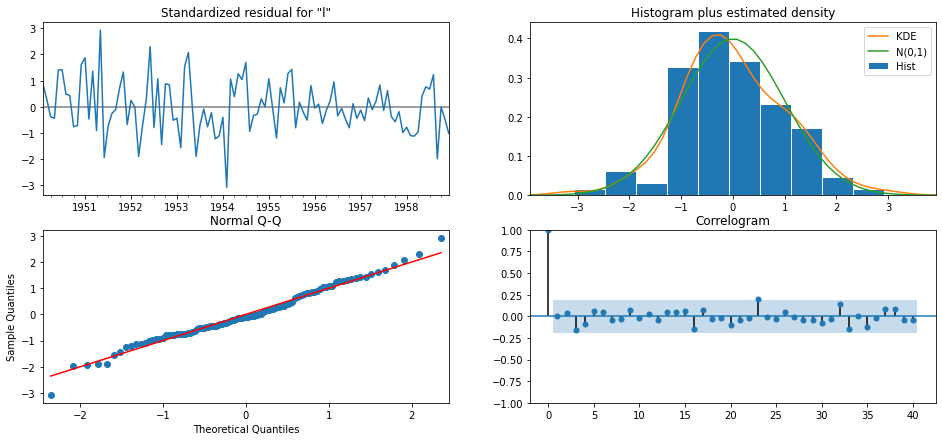

In [ ]:
sarima_result.plot_diagnostics(lags=40)
plt.show()

- The residual's ACF plot (correlogram) does not show autocorrelation.
- The histogram and QQPlot show that the residuals fit a good normal distribution.

#### **b)** The portmanteau test

The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.
- $H_0$: The residuals are independently distributed.
- $H_A$: The residuals are not independently distributed

Ideally, we would like to fail to reject the null hypothesis.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(sarima_result.resid, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.001212,0.972228
2,0.123587,0.940077
3,0.133404,0.987548
4,0.133698,0.997863
5,0.166668,0.999432
6,0.170722,0.999903
7,0.185321,0.999981
8,0.199689,0.999996
9,0.236102,0.999999
10,0.354550,0.999999


p_value > 0.05. Thus, we do not reject the null hypothesis of the test and conclude that the residuals are independent.

Durbin-Watson test
- $H_0$ : there is no correlation among the residuals
- $𝐻_𝐴$ : The residuals are autocorrelated

In [ ]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(sarima_result.resid)

1.2198794810784848

The test statistic will always be between 0 and 4 with the following interpretation:
- A test statistic of 2 indicates no serial correlation.
- The closer the test statistics is to 0, the more evidence of positive serial correlation.
- The closer the test statistics is to 4, the more evidence of negative serial correlation.

If test statistic values between the range of 1.5 and 2.5 are considered normal. However, values outside of this range could indicate that autocorrelation is a problem.

#### **C)** Checking for normality


In [ ]:
pd.DataFrame(sarima_result.test_normality('jarquebera'), columns=['JB t-statistic', 'p-value', 'skew', 'kurtosis'])

,JB t-statistic,p-value,skew,kurtosis
0,0.938216,0.62556,0.120961,3.389762


- p-value > 0.05, so the data is normally distributed.
- Skew = 0.12: no skew
- A Normal distribution has a kurtosis of 3, The kurtosis of this model is 3.38 --> it approximately follows a normal distribution.

## Forecast

In [ ]:
def plot_forecast(model, start, train, test, title):
  forecast = pd.DataFrame(np.exp(model.forecast(test.shape[0])),index=test.index)
  ax = train.loc[start:].plot(style='--')
  test.plot(ax=ax)
  forecast.plot(ax=ax, style = '-.')
  ax.legend(['orig_train', 'orig_test', 'forecast'])
  plt.title(title)
  plt.show()

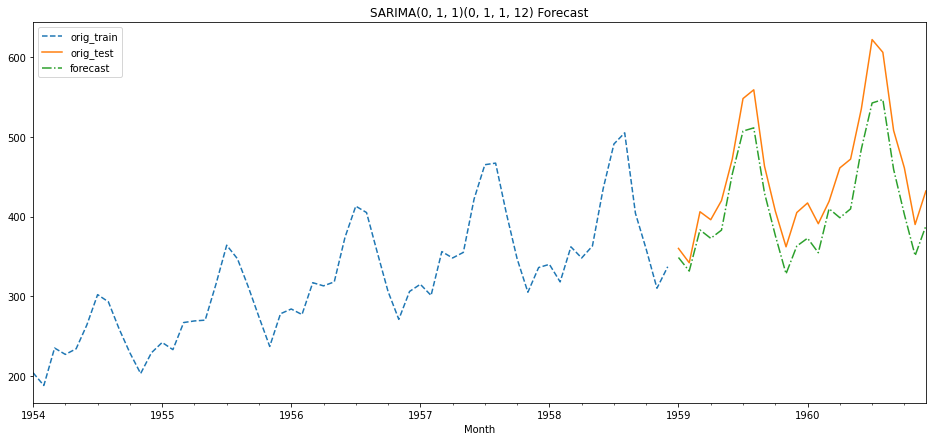

In [ ]:
# Plot forecast
plot_forecast(sarima_result, '1954', train['Passengers'], test['Passengers'], 'SARIMA(0, 1, 1)(0, 1, 1, 12) Forecast')


In [ ]:
test['sarima_forecast'] = np.exp(sarima_result.forecast(test.shape[0])).astype('int')
test.head()

,Passengers,log(passengers),sarima_forecast
Month,,,
1959-01-01,360,5.886104,348
1959-02-01,342,5.834811,331
1959-03-01,406,6.006353,383
1959-04-01,396,5.981414,372
1959-05-01,420,6.040255,382


In [ ]:
sarima_mae = mean_absolute_error(test['sarima_forecast'].values, test['Passengers'].values)
sarima_mape = mean_absolute_percentage_error(test['sarima_forecast'].values, test['Passengers'].values)

metrics = ['MAE', 'MAPE']
SARIMA_errors = [sarima_mae, sarima_mape]

error_df = pd.DataFrame({'metrics': metrics, 'SARIMA(0,1,1)(0,1,1,12)': SARIMA_errors})
error_df

,metrics,"SARIMA(0,1,1)(0,1,1,12)"
0,MAE,39.958333
1,MAPE,0.095791


For SARIMA(0, 1, 1)(0, 1, 1, 12):
- The mean absolute error, MAE = 40, is the average (absolute) difference between the actual value and the forecasted value.
- The MAPE value of 9.58% means that the average difference between the forecasted value and the actual value is 9.58%.

#### Seasonal Holt-Winter Method

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

trend , damped = ['add', 'mul'], [True, False]
seasonal = ['add' , 'mul']
exp_comb = combinator([trend, damped, seasonal])

X = train['log(passengers)'].values.ravel()
y = test['log(passengers)'].values.ravel()
model_scores = {}
for i, (t, dp, s) in enumerate(exp_comb):
  exp = ExponentialSmoothing(X, 
                             trend=t, damped_trend=dp, 
                             seasonal=s, seasonal_periods=12)
  model = exp.fit(use_brute=True, optimized=True)
  y_hat = model.forecast(len(y))
  model_scores[i] = {'trend':t,
                      'damped':dp,
                     'seasonal':s,
                          'AIC':model.aic,
                          'BIC':model.bic,
                          'AICc': model.aicc,
                          'RMSE' : np.sqrt(mean_squared_error(y, y_hat)),
                          'MAPE' : mean_absolute_percentage_error(y, y_hat),
                          'model': model}

In [ ]:
pd.DataFrame(model_scores).T.sort_values(by='AIC').reset_index().head()

,index,trend,damped,seasonal,AIC,BIC,AICc,RMSE,MAPE,model
0,3,add,False,mul,-780.4137,-735.813833,-773.641423,0.051668,0.007323,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,5,mul,True,mul,-778.585454,-731.198095,-770.985454,0.182206,0.024754,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,7,mul,False,mul,-771.252388,-726.65252,-764.480111,0.057898,0.008364,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,1,add,True,mul,-769.982338,-722.594979,-762.382338,0.099006,0.014817,<statsmodels.tsa.holtwinters.results.HoltWinte...
4,2,add,False,add,-769.603446,-725.003578,-762.831169,0.076982,0.011275,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [ ]:
model = get_best_model(model_scores)

Best model: 3 with lowest AIC score: -780.4137003984277


In [ ]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  120
Model:             ExponentialSmoothing   SSE                              0.138
Optimized:                         True   AIC                           -780.414
Trend:                         Additive   BIC                           -735.814
Seasonal:                Multiplicative   AICC                          -773.641
Seasonal Periods:                    12   Date:                 Fri, 09 Dec 2022
Box-Cox:                          False   Time:                         09:14:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6944890                alpha                 True
smoothing_trend          

### Test the model

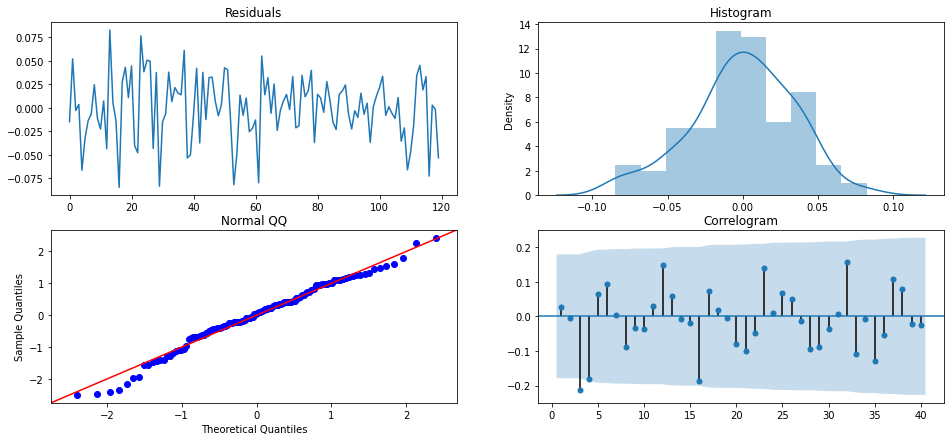

In [ ]:
# Plot
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

f, (ax1, ax2) = plt.subplots(2, 2)
ax1[0].plot(model.resid)
ax1[0].set_title('Residuals')

sns.distplot(model.resid, bins=10, ax=ax1[1])
ax1[1].set_title('Histogram')

qqplot(model.resid,norm,fit=True,line="45", ax=ax2[0])
ax2[0].set_title('Normal QQ')

plot_acf(model.resid, zero=False, lags=40, ax=ax2[1])
ax2[1].set_title('Correlogram')
plt.show()

In [ ]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

print(f'Durbin Watson test: {durbin_watson(model.resid)}')
print('Ljung-box test: ')
acorr_ljungbox(model.resid, lags=10, return_df=True)

Durbin Watson test: 1.9267694424409985
Ljung-box test: 


,lb_stat,lb_pvalue
1,0.080025,0.777264
2,0.082430,0.959623
3,5.687393,0.127850
4,9.779006,0.044319
5,10.295901,0.067272
6,11.402031,0.076718
7,11.402884,0.121985
8,12.431775,0.132954
9,12.586943,0.182204
10,12.753299,0.237794


p_value > 0.05. Thus, we do not reject the null hypothesis of the test and conclude that the residuals are independent.

In [ ]:
from scipy.stats import shapiro, normaltest

print(f'Shapiro test: {shapiro(model.resid)[1]}')

print(f'Normal test: {normaltest(model.resid)[1]}')

Shapiro test: 0.15924426913261414
Normal test: 0.27182252363757825


p-values > 0.05, the residual series follows a normal distribution.

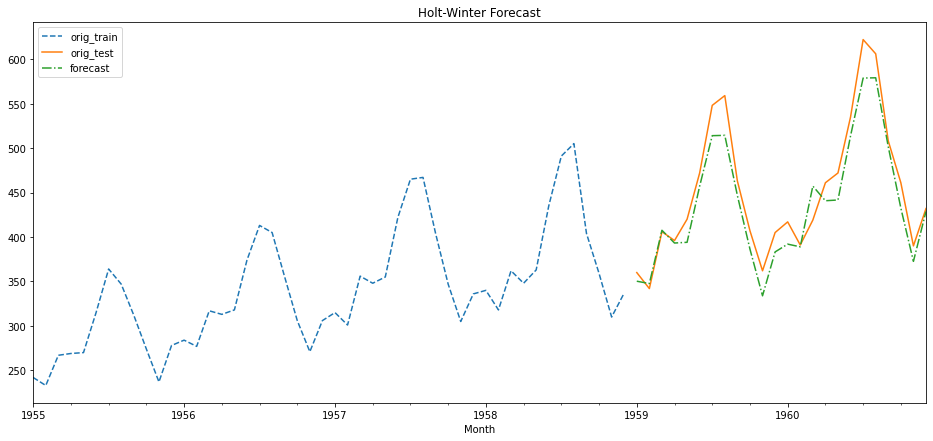

In [ ]:
# Forecasting
plot_forecast(model, '1955', train['Passengers'], test['Passengers'], 'Holt-Winter Forecast')

In [ ]:
test['expsmoothing_forecast'] = np.exp(model.forecast(test.shape[0])).astype('int')
test.head()

,Passengers,log(passengers),sarima_forecast,expsmoothing_forecast
Month,,,,
1959-01-01,360,5.886104,348,350
1959-02-01,342,5.834811,331,347
1959-03-01,406,6.006353,383,407
1959-04-01,396,5.981414,372,393
1959-05-01,420,6.040255,382,394


In [ ]:
test_mae = mean_absolute_error(test['expsmoothing_forecast'].values, test['Passengers'].values)
test_mape = mean_absolute_percentage_error(test['expsmoothing_forecast'].values, test['Passengers'].values)

EXP_errors = [test_mae, test_mape]

error_df['Holt-Winter'] = EXP_errors
error_df

,metrics,"SARIMA(0,1,1)(0,1,1,12)",Holt-Winter
0,MAE,39.958333,20.791667
1,MAPE,0.095791,0.046858


For Holt-Winter model:
- The mean absolute error, MAE = 21, is the average (absolute) difference between the actual value and the forecasted value.
- The average difference between the forecasted value and the actual value is 4.68%.

The best model we have got so far with the lowest MAE and lowest MAPE is Holt-Winter.